# This is a public notebook example on using the explicit Jacobi iteration and the V_cycle for the 2D electrostatic potential Problem. 

### Following Code focuses on Multiprocessing the explicit Jacobi method on CPU using the cython.parallel.prange function

We begin by loading the Cython extension and the appropriate modules.
~ Note> The multiprocessing (mp) module does not work properly in the Jupyter notebook which is why we are using prange.

We define all appropriate functions:

- The 'display' function uses the PIL.Image and takes a 2D array as input to translate into an image. The np.uint8 is the color scheme and bit depth


- The 'jacobi_iteration' performs one full sweep of a given array representation. It has no return so we define it as a void function. It takes as input a 2D array A of 64bit float numbers, and an integer Mask. The Mask serves as a literal Masking method for Dirichlet boundary conditions. Where mask[i,j] = 0 the function will not iterate over. These represent constant values in our Potential A (hence Dirichlet boundary conditions). The Method is being worked on to incorporate Neuman and Mixed B.C. This is where the Multiprocessing happens. There are 2 ways of doing this. Row-Major or Column-Major. You can assign the prange operator in the first for loop. In this case one core will be occupied iterating a whole column by itself, while other cores iterate the next Columns independantly. This is the Row-Major case. In puting the prange operator in the second for loop, the core will iterate each element of the Column independently (remember for1 iterates rows, for2 iterates inside columns), and essentially the next Row gets iterated when all core-workers are done doing this single Column.
    ~The reason why you should put the prange in the First For loop is simple. The overhead to call CPU workers might be larger than the amount of time needed to iterate a whole column. So by the time Windows calls for example 15 more CPU cores to solve Algebra on the second iteration of the 'j' loop, that 1 Core that started iterating that 'j' Column is already done doing the Algebra that the other 16 cores are getting called for, and the second for loop over 'i' begins since the'j' are done. Now Windows has to spend the same amount of time calling 15 Cores while Core 1 already finished iteration nr.2 over 'i'. Putting prange in the first loop mitigates this, because we are guaranteed that the other cores are called to iterate over 'i' and not over 'j' (You have no conflict of interest).
       Note!!! => Because this function iterates from 1 => n/m-1 It always represents edges as Dirichlet B.c. This allows us to use them as Ghost Indeces for Neuman B.c where we need to adjust the values to match a derivative of choice.
       For example A[0] = A[3] means
       
       
$$
\dfrac{d}{dx}=0
$$


    In this specific function i will use the Boundaries as static Dirichlet conditions with cosinus functions on them.
    Yes color scaling in PIL is hell but matplotlib does not support full resolution render and saving with simple syntax.
- The 'Jacobi_fx' uses the 'jacobi_iteration' continiously until a certain number of maximum iterations is reached, or until a convergence criterion is reached. This is represented by the 'error' variable. It is measured by doing the L2 Norm of the array, saving it, then calculating the difference with the L2 norm of the next iteration. Once the L2 norm is small enough (represented by our given error) the iterations stop. The function returns the potential A, the number of iterations and the reached error.


- The 'create_circle' function takes as input an array/Matrix and a Mask matrix along with center coordinates of a circle relative to the index coordinates. It uses the Indexes as the drawing Field along with the mathematical Circle equation x**2 + y**2 = r**2 to fill the insides of a circle of radius R centered at (x,y). Where x and y are given in index coordinates (i.e they cannot exceed the maximum resolution number -1). The function can be used to fill or hollow out aswell by setting the value to 0 and the mask int to 1 so that is is set as a field coordinate again and not a Dirichlet condition.

The 'Jacobi_fx' has to be defined a cPython function because it will ideally be called in another script if you are working with .pyx files or in other Cells if you are using Jupyter. Same argument for the 'display' function


Testing is done by creating an array of 4K resolution (2160 x 3840 => 8,294,400 elements) (on my AMD 5950x with all cores at 4.6 Ghz this took around 4 minutes) and a Mask of the appropriate size.

    !!Note: This test can be done at 1080p resolution so that it runs a bit faster on other machines. Just remember to input the correct paramteres everywhere

The potential is filled with 2 Electrodes. 1 Annulus set to +30 V and one filled Circle inside it set at -35 V. The indeces where these Electrodes are represented in the Potential Array, are also representing equal = '0' Elements in our Mask. After all,  the Electrodes are Static and we only need to calculate the Electric Field/Potential around them. (They represent Dirichlet conditions). The Edges of the electrodes can also become Neuman boundaries or mixed boundaries, but that is a work in progress.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext Cython

## The Cython cell below has the necessary methods needed. Tried to avoid wrapper functions by using the cpdef formality (overhead is minimal)

In [3]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
cimport cython
from cython.parallel import prange
cimport numpy as np
import operator


cpdef display(field):
    return Image.fromarray(np.uint8(field))



@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef void jacobi_iteration(double[:,:] A, double[:,:] mask):
    cdef int i, j, n, m
    cdef double tmp
    n, m = A.shape[0], A.shape[1]
    for i in prange(1, n-1, nogil=True):
        for j in range(1, m-1):
            if not mask[i, j]:
                tmp = 0.25 * (A[i-1, j] + A[i+1, j] + A[i, j-1] + A[i, j+1])
                A[i, j] = tmp
      

    
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef Jacobi_fx(double[:,:] A, double[:,:] mask, int max_iterations, double error):
    cdef int i, n, m, iteration
    cdef double norm, norm_prev, tmp_error
    norm_prev = 0
    norm = 0
    iteration = 0
    n, m = A.shape[0], A.shape[1]
    for i in range(max_iterations):
        norm = np.linalg.norm(A)
        jacobi_iteration(A, mask)
        tmp_error = abs(norm - norm_prev)
        norm_prev = norm
        iteration = iteration + 1
        if tmp_error < error:
            break
    return A, tmp_error, iteration

#These have to be optimized still.
#NOTE: Their Cython version is still unders testing.
def coarsen_potential(potential, index_truncation_factor):
    coarsened_potential = np.zeros((int(potential.shape[0] * index_truncation_factor),
                                    int(potential.shape[1] * index_truncation_factor)))
    inv = int(1/index_truncation_factor)
    for i in range(coarsened_potential.shape[0]):
        for j in range(coarsened_potential.shape[1]):
            coarsened_potential[i, j] = np.mean(potential[i * inv:i * inv + inv, j * inv:j * inv + inv])
    return coarsened_potential


def smooth_potential(potential, index_prolongation_factor):
    smoothed_potential = np.zeros((int(potential.shape[0] * index_prolongation_factor),
                                   int(potential.shape[1] * index_prolongation_factor)))
    for i in range(potential.shape[0]):
        for j in range(potential.shape[1]):
            smoothed_potential[i * index_prolongation_factor:(i + 1) * index_prolongation_factor,
                               j * index_prolongation_factor:(j + 1) * index_prolongation_factor] = potential[i, j]
    return smoothed_potential

def smooth_potential_2(potential, target_height, target_width):
    index_prolongation_factor_height = int(target_height / potential.shape[0])
    index_prolongation_factor_width = int(target_width / potential.shape[1])
    smoothed_potential = np.zeros((target_height, target_width))
    for i in range(potential.shape[0]):
        for j in range(potential.shape[1]):
            smoothed_potential[i * index_prolongation_factor_height:(i + 1) * index_prolongation_factor_height, j * index_prolongation_factor_width:(j + 1) * index_prolongation_factor_width] = potential[i, j]
    return smoothed_potential





@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef void create_circle(double[:,:] matrix, double[:,:] mask, double x, double y, double radius, double value, double m_value, str param):
    operators = {'>': operator.gt,
           '<': operator.lt,
           '>=': operator.ge,
           '<=': operator.le,
           '==': operator.eq}
    cdef int i, j
    cdef int rows = matrix.shape[0]
    cdef int cols = matrix.shape[1]
    for i in range(rows):
        for j in range(cols):
            if operators[param](((i-y)*(i-y) + (j-x)*(j-x)), radius*radius):
                matrix[i, j] = value
                mask[i, j] = m_value

                
                
                
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef void set_dirichlet(double[:,:] array, double[:,:] mask):
    cdef int i, j
    cdef int rows = array.shape[0]
    cdef int cols = array.shape[1]
    for i in range(rows):
        for j in range(cols):
            if mask[i, j]:
                array[i, j] = mask[i, j]
                
                

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef up_cycle(double [:,:] potential, double[:,:] mask, int total_samples, int inner_iterations, double index_truncation_factor):
    
    #start by preparing the downsized samples and masks
    #cdef double[:] sample_masks = np.empty((total_samples), dtype=float)
    cdef list sample_masks = []
    cdef list modifiable_potential = []
    
    #the ints that iterate inside for loops below
    cdef int number, inner_it
    
    
    #the starting potential in its lowest desired resolution
    modifiable_potential.append(coarsen_potential(potential, index_truncation_factor*(1/total_samples)))
    #append OG mask to list of masks to be downscaled
    sample_masks.append(mask)
    
    #create array to store masks
    for number in range(total_samples):
        sample_masks.append(coarsen_potential(mask, index_truncation_factor*(1/(number+1))))
        
    for m_sample in reversed(sample_masks):
        set_dirichlet(modifiable_potential[0], m_sample)
        for inner_it in range(inner_iterations):
            jacobi_iteration(modifiable_potential[0], m_sample)
        modifiable_potential[0] = smooth_potential_2(modifiable_potential[0], m_sample.shape[0], m_sample.shape[1])
    return modifiable_potential[0]
            
        
        

In [4]:
#create the cut wire example 
res = (1080, 1920) #The domain resolution.
potential = np.zeros(res)
mask = np.zeros(res, dtype=float)
center_y, center_x = potential.shape[0]//2, potential.shape[1]//2
radius = 750
hollow_radius = 650
small_radius = 400
pot_val = 30.



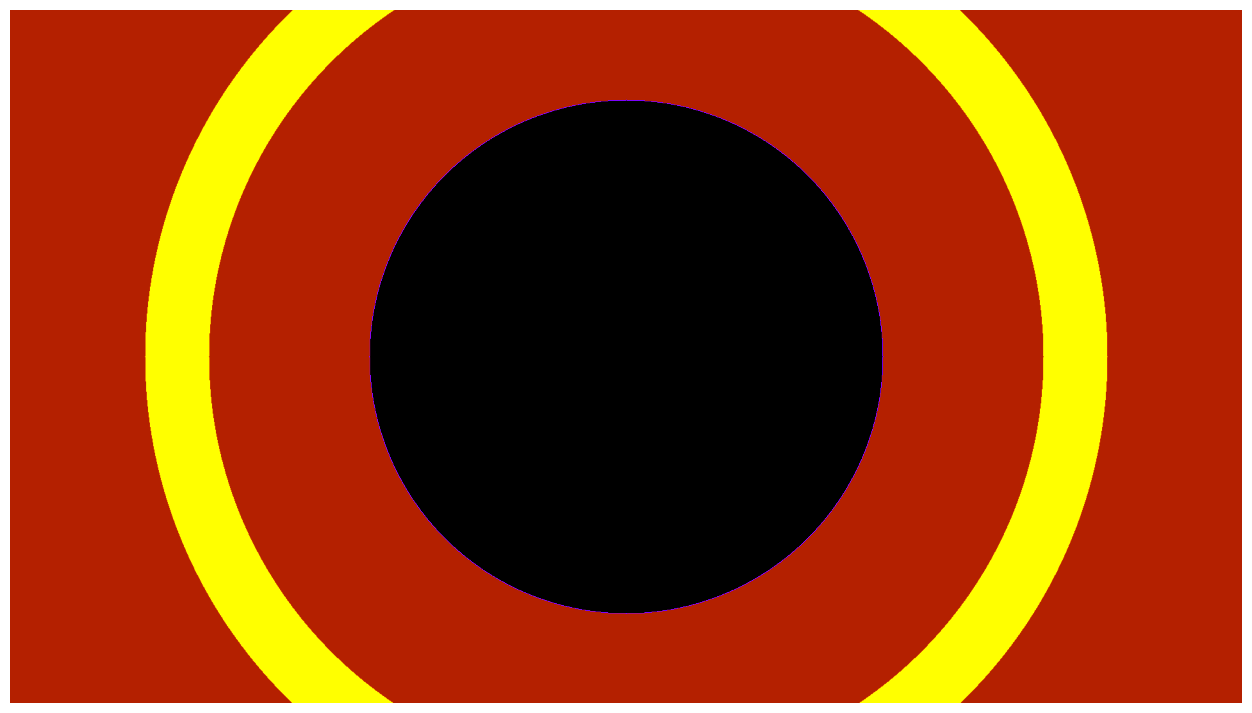

In [5]:
create_circle(potential, mask, center_x, center_y, radius, 30., 30., '<=')
create_circle(potential, mask, center_x, center_y, hollow_radius, 0., 0, '<=')
create_circle(potential, mask, center_x, center_y, small_radius, -30., -30., '<=')
plt.figure(figsize = (16, 9))
plt.axis('off')
image = plt.imshow(potential)
image.set_cmap('gnuplot')

plt.show()

In [ ]:
plt.imshow(mask)

In [ ]:
potential.shape, mask.shape

In [6]:
total_samples = 8
inner_iterations = 20
index_truncation_factor = 0.5

In [7]:
sample_masks=[]
sample_masks.append(mask)
for number in range(total_samples):
    sample_masks.append(coarsen_potential(mask, index_truncation_factor*(1/(number+1))))
    
modifiable_potential=[]
modifiable_potential.append(coarsen_potential(potential, index_truncation_factor*(1/(total_samples))))

In [8]:
for i in range(9):
    print (sample_masks[i].shape)

(1080, 1920)
(540, 960)
(270, 480)
(180, 320)
(135, 240)
(108, 192)
(90, 160)
(77, 137)
(67, 120)


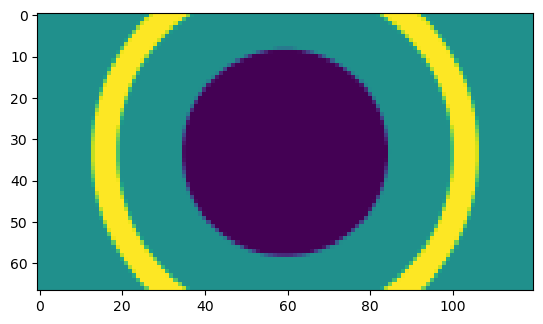

In [10]:
plt.imshow(sample_masks[8])

In [11]:
kkk = smooth_potential_2(modifiable_potential[0], 1080, 1920)
set_dirichlet(kkk, sample_masks[0])

In [13]:
for i in range(2000):
    jacobi_iteration(kkk, sample_masks[0])

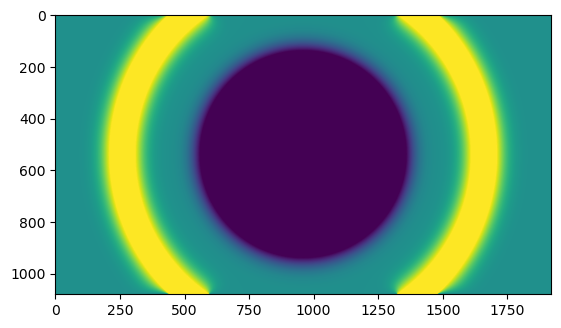

In [14]:
plt.imshow(kkk)

In [ ]:
set_dirichlet(aa, sample_masks[0])

In [ ]:
plt.imshow(aa)

In [ ]:
kkk = smooth_potential_2(modifiable_potential[0], 1080, 1920)

In [ ]:
plt.imshow(kkk), kkk.shape

In [ ]:
set_dirichlet(kkk, sample_masks[0])

In [ ]:
plt.imshow(kkk)

In [ ]:
sample_masks[3].shape[1]

In [ ]:
aaa = smooth_potential_2(modifiable_potential[0], sample_masks[3].shape[0], sample_masks[3].shape[1])

In [ ]:
plt.imshow(aaa)

In [ ]:
testing = up_cycle(potential, mask, 4, 3000, 0.5)

In [ ]:
plt.imshow(testing)

In [ ]:
def p_void up_cycle(potential, mask, total_samples, inner_iterations, index_truncation_factor):
    
    #start by preparing the downsized samples and masks
    #cdef double[:] sample_masks = np.empty((total_samples), dtype=float)
    sample_masks = []
    modifiable_potential = []
    
    #the ints that iterate inside for loops below
    
    
    
    #the starting potential in its lowest desired resolution
    modifiable_potential[0] = coarsen_potential(potential, index_truncation_factor*(1/total_samples))
    
    #create array to store masks
    for number in range(total_samples):
        sample_masks[number] = coarsen_potential(mask, index_truncation_factor*(1/(number+1)))
        
    for m_sample in reversed(sample_masks):
        set_dirichlet(modifiable_potential[0], m_sample)
        for inner_it in range(inner_iterations):
            jacobi_iteration(modifiable_potential[0], m_sample)
        tmp = smooth_potential(modifiable_potential[0], 1/index_truncation_factor)
        modifiable_potential[0] = tmp

### Here next we create the electrodes. The first Call of 'create_circle' creates the outter circle filled
### The second Call equalizes the potential inside to another Radius and creates the Annulus shape
### The third call creates the innermost 2nd Electrode filled inside.

In [ ]:
kappa = coarsen_potential(mask, 0.5/6)
plt.imshow(kappa)

In [ ]:
kappa.shape

In [ ]:
kappa2 = smooth_potential(kappa, 3)
kappa2.shape
plt.imshow(kappa2)

# Now let's calculate and render

In [ ]:
%%time
iterations = 10000
error = 0.3

##
solution = Jacobi_fx(potential, mask, iterations, error)
##



In [ ]:
solution[1], solution[2]

In [ ]:
solution[0] 
#This is our final array to render. Our resulting potential.

## As we can see it took around 256 seconds to complete. It calculated 8138 out of 10 000 max iterations, on an error of 0.29999.. That equates to a render rate of 31.789 FPS (frames per second) in our Per-Pixel resolution of 3840x2160 (4K). On a 1080p Matrix this would take around 4 times less to complete given the same parameters.

## The whole Matrix and software running (only notebook) took around 9.89 GB of RAM and used a single thread per CPU core, giving an overallutilization of 52-54% at Clocks of 4.5-4.7 Ghz on 16 physical Cores, 32 Threads.

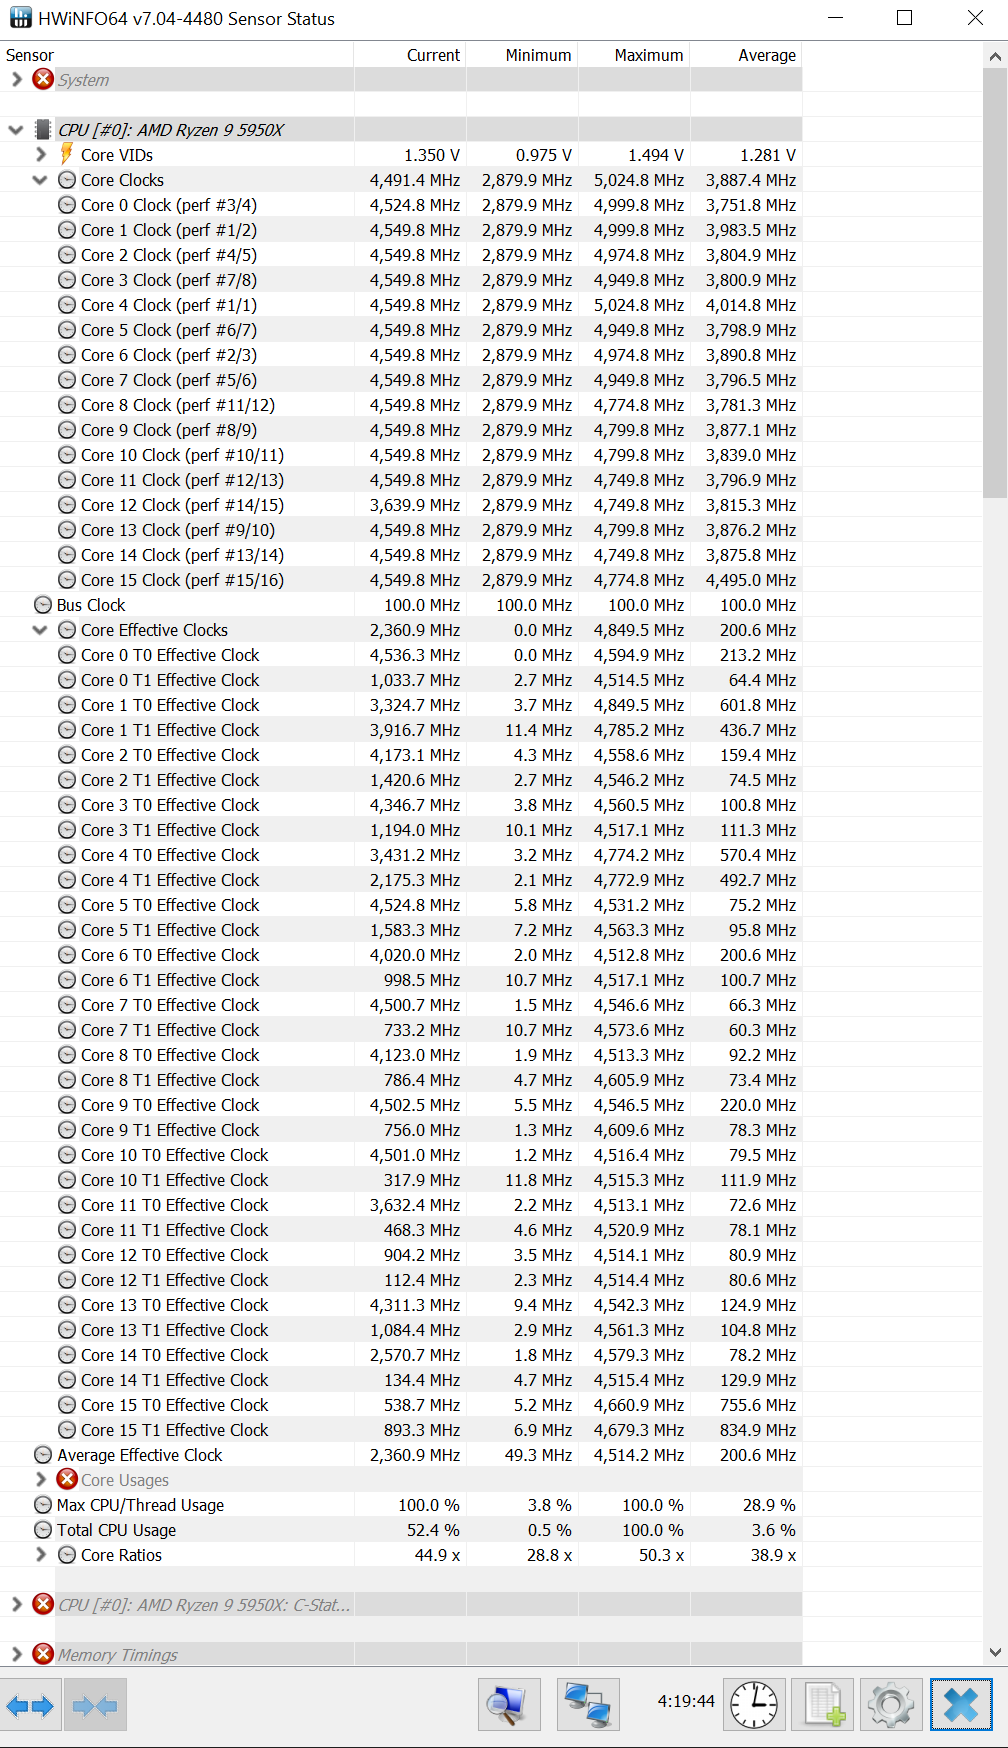

In [ ]:
plt.figure(figsize = (16, 9))
plt.axis('off')
image2 = plt.imshow(solution[0])
image2.set_cmap('gnuplot')

plt.show()

In [ ]:
#field lines
dy, dx = np.gradient(solution[0])
xv, yv = np.meshgrid(np.linspace(0, 1, res[1]), np.linspace(0, 1, res[0]))


In [ ]:
plt.figure(figsize = (16, 9))
plt.axis('off')
plt.streamplot(xv, yv, -dx, -dy, density=4, color='black', arrowstyle='simple')
#yes they have to be -dx -dy don't ask me why ask numpy ^-^
plt.title("Electric field of the Cython Jacobi-method calculated potential")
#field lines flow from the positive potential to negative

We can see interesting features in the field. The Electrodes at higher potential on the sides have denser electric fields. More lines represent them.

# Now let us try to manually check what happens during coarsening

In [ ]:
solution[0].shape

In [ ]:
c_pot_half = coarsen_potential(solution[0], 0.5)

c_pot_half.shape

In [ ]:
plt.figure(figsize = (16, 9))
plt.set_cmap('gnuplot')
plt.axis('off')
plt.imshow(c_pot_half)

In [ ]:
plt.imshow(mask)

In [ ]:
# Does not work on mask

c_mask_half = coarsen_potential(mask, 0.05)
plt.imshow(c_mask_half)

In [ ]:
plt.imshow(solution[0], cmap='gnuplot')

In [ ]:
%%time
iterations = 10000
error = 0.3

##
solution_c_half = Jacobi_fx(c_pot_half, c_mask_half, iterations, error)
##


In [ ]:
plt.imshow(solution_c_half[0])

In [ ]:
c_mask_half2 = np.asarray(np.rint(coarsen_potential(mask, 0.02)), dtype='int')
plt.imshow(c_mask_half2)

In [ ]:
test = coarsen_potential(mask, 0.02)
plt.imshow(test)

In [ ]:
"""
more interesting boundaries on the edges ^_^
testside = np.linspace(0.0, 8*np.pi, num=res[0])
testup = np.linspace(0.0, 8*np.pi, num=res[1])

potential[:,0]=35*(np.cos(2*testside))
potential[:,-1]=35*(np.cos(2*testside))
potential[0,:]=35*(np.cos(2*testup))
potential[-1,:]=35*(np.cos(2*testup))
"""

In [ ]:
c_mask_half2.shape

In [ ]:
k = 7
for i in reversed(k):
    print(i)

In [ ]:
hehe= np.array([1])
aa = np.zeros([1])
hehe

In [ ]:
aa[0]= hehe
aa[0].type